## Mask-RCNN model (image size 416x416)

**Seting up Google Cloud configurations to run the**

In [ ]:
## giving notebook access to the google cloud 
!gsutil config -a

This command will configure HMAC credentials, but gsutil will use
OAuth2 credentials from the Cloud SDK by default. To make sure the
HMAC credentials are used, run: "gcloud config set
pass_credentials_to_gsutil false".

Backing up existing config file "/root/.boto" to "/root/.boto.bak"...
This command will create a boto config file at /root/.boto containing
your credentials, based on your responses to the following questions.
What is your google access key ID? GOOGCXCX2MN35QLUMAM2HS4I
What is your google secret access key? w2OWUXLCW2ImFLvQHMni9rTTLVa/6Vrx1I42Y0TA

Boto config file "/root/.boto" created. If you need to use a proxy to
access the Internet please see the instructions in that file.


In [ ]:
## pulling the data from the cloud storage to the notebook
project_id = 'capstone-341807'

!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://data_folder_123/


In [ ]:
from google.colab import auth
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   165k      0 --:--:-- --:--:-- --:--:--  176k
OK


In [ ]:
!apt -qq update
!apt -qq install gcsfuse

101 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 101 not upgraded.
Need to get 12.0 MB of archives.
After this operation, 28.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.40.0_amd64.deb ...
Unpacking gcsfuse (0.40.0) ...
Setting up gcsfuse (0.40.0) ...


In [ ]:
!mkdir colab_directory
!gcsfuse --implicit-dirs data_folder_123 colab_directory
## exploring the files into the colab_directory
!ls colab_directory

2022/02/19 09:13:28.436413 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/colab_directory
2022/02/19 09:13:28.445697 Opening GCS connection...
2022/02/19 09:13:28.618197 Mounting file system "data_folder_123"...
2022/02/19 09:13:28.646857 File system has been successfully mounted.


**installing neccessary libraries**

In [ ]:
## installing some older verisions since some of the libraries that
## we use here haven't been updated

!pip install h5py==2.10.0 --quiet
!pip install q keras==2.1.6 --quiet
!pip install tensorflow==1.14 --quiet

In [ ]:
## checking if we have the correct version of tensorflow
import tensorflow as tf
print(tf.__version__)

1.14.0


In [ ]:
import os
import sys
import random
import math
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import keras
from google.colab import drive
from sklearn.model_selection import train_test_split

In [ ]:
## clonining libraries that will be used to build MRCNN model
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 38.04 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [ ]:
## Setting up paths to different directories
ROOT_DIR = '/content/colab_direcoty'

mrcnn_path = '/content/Mask_RCNN'


# Import Mask RCNN from the drive
sys.path.append(mrcnn_path) 

from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import utils
import mrcnn.model
import mrcnn.model as modellib
from mrcnn.visualize import display_images
from mrcnn import visualize
from mrcnn.model import MaskRCNN

In [ ]:
# Download and install the Python COCO tools from https://github.com/waleedka/coco
!git clone https://github.com/waleedka/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 904, done.
remote: Total 904 (delta 0), reused 0 (delta 0), pack-reused 904
Receiving objects: 100% (904/904), 10.39 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (539/539), done.


In [ ]:
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))

# Importing COCO from the drive
import coco
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
from pycocotools import mask

**Exploring the dataset**

In [ ]:
# Directory of images in drive
D2S_DATSET_DIR = '/content/colab_directory'

## annotations of images 
annotations= os.path.join(D2S_DATSET_DIR, 'd2s_annotations_v1/D2S_validation.json')
coco=COCO(annotations)
class_ids = sorted(coco.getCatIds())

## exrating unique class ids
print("Classes:")
cat_names = []
for i in class_ids:
  print(i,'-', coco.loadCats(i)[0]["name"])
  cat_names.append(coco.loadCats(i)[0]["name"])

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
Classes:
1 - adelholzener_alpenquelle_classic_075
2 - adelholzener_alpenquelle_naturell_075
3 - adelholzener_classic_bio_apfelschorle_02
4 - adelholzener_classic_naturell_02
5 - adelholzener_gourmet_mineralwasser_02
6 - augustiner_lagerbraeu_hell_05
7 - augustiner_weissbier_05
8 - coca_cola_05
9 - coca_cola_light_05
10 - suntory_gokuri_limonade
11 - tegernseer_hell_03
12 - corny_nussvoll
13 - corny_nussvoll_single
14 - corny_schoko_banane
15 - corny_schoko_banane_single
16 - dr_oetker_vitalis_knuspermuesli_klassisch
17 - koelln_muesli_fruechte
18 - koelln_muesli_schoko
19 - caona_kakaohaltiges_getraenkepulver
20 - cocoba_fruehstueckskakao_mit_honig
21 - cafe_wunderbar_espresso
22 - douwe_egberts_professional_kaffee_gemahlen
23 - gepa_bio_caffe_crema
24 - gepa_italienischer_bio_espresso
25 - apple_braeburn_bundle
26 - apple_golden_delicious
27 - apple_granny_smith
28 - apple_roter_boskoop
29 - avocado
30 

**Convert the dataset to COCO format**

In [ ]:
# Root directory of the project
sys.path.append(os.path.join(ROOT_DIR, "mrcnn/")) 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

annotations= os.path.join(D2S_DATSET_DIR, 'd2s_annotations_v1/D2S_validation.json')
coco=COCO(annotations)

classes = coco.loadCats(coco.getCatIds())
catIds=[cat['id'] for cat in classes]

imgids=[]
for i, value in enumerate(catIds):
    imgid=coco.getImgIds(catIds=catIds[i])
    imgids.extend(imgid)

imgids = list(set(imgids))
imgDict = coco.loadImgs(imgids)
img1 = pd.DataFrame.from_dict(imgDict)
data_list1=img1.filter(['file_name','id'])

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


**Splitting the data**

In [ ]:
X_train,X_val1 = train_test_split(data_list1,test_size=0.2, random_state=42,
                                 shuffle=True)
X_val,X_test = train_test_split(X_val1,test_size=0.5, random_state=42,
                                 shuffle=True)
img_id_train=X_train['id']
img_id_dev=X_val['id']
img_id_test = X_test['id']
X_train=X_train['file_name']
X_val=X_val['file_name']
X_test = X_test['file_name']
X_train.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

In [ ]:
## this was adapted from COCO dataset sample
class D2S_Dataset(utils.Dataset):
    def load_d2s(self,subset):
        
        #annotation path
        annFile= annotations
        coco=COCO(annotations)  
        
        dataset_dir= D2S_DATSET_DIR
        assert subset in ["train", "val"]
            
        image_dir = os.path.join(D2S_DATSET_DIR, 'images')
        
        if subset == "train" : 
            image_ids=img_id_train
        else:
            image_ids=img_id_dev
            
        # Add classes
        class_ids = sorted(coco.getCatIds())
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(imgIds=[i], iscrowd=False)))
        

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(self.__class__).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        
        # Build mask of shape [height, width, instance_count] 
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                if m.max() < 1:
                    continue
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(self.__class__).load_mask(image_id)

    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(self.__class__).image_reference(self, image_id)

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [ ]:
def coco_results(dataset, image_ids, res, class_ids, scores, masks):

    # If no results, return an empty list
    if res is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(res.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(res[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "coco"),
                "bbox": [bbox[1], bbox[0], bbox[3]-bbox[1], bbox[2]-bbox[0]],
                "score": score,
                "segmentation": maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results

In [ ]:
## converting each subset of the the data to COCO format
dataset_train = D2S_Dataset()
dataset_train.load_d2s(subset="train")
dataset_train.prepare()

dataset_val = D2S_Dataset()
dataset_val.load_d2s(subset="val")
dataset_val.prepare()

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


**Building the model**

In [ ]:
class Model_Config(Config):
    NAME = "D2S"
    
    ## setting up the configurantions for training stage 
    LEARNING_RATE =0.002
    STEPS_PER_EPOCH= 100   
    GPU_COUNT =  1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 60 
    
    ## we will use resnet50 for feature extraction
    BACKBONE = "resnet50"
    IMAGE_MIN_DIM = 416
    IMAGE_MAX_DIM = 416

class Set_Config(Model_Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

configurations = Set_Config()

In [ ]:
model_architecture = Model_Config()
model_architecture.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  416
IMAGE_META_SIZE                73
IMAGE_MIN_DIM                  416
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [416 416   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

**Model Training**

In [ ]:
COCO_MODEL_PATH = '/content/Mask_RCNN/mask_rcnn_coco.h5'

model = modellib.MaskRCNN(mode="training", config=configurations, model_dir=MODEL_DIR)

#model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
history = model.train(dataset_train, dataset_val,
                learning_rate=configurations.LEARNING_RATE,
                epochs=100, layers='all')


Starting at epoch 0. LR=0.002

Checkpoint Path: /content/colab_direcoty/logs/d2s20220219T0934/mask_rcnn_d2s_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b 

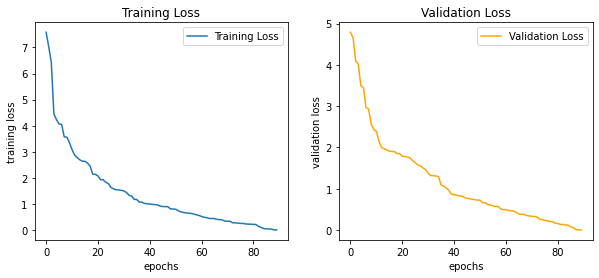

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.title('Validation Loss')
plt.show()

**Making prediction with the model**

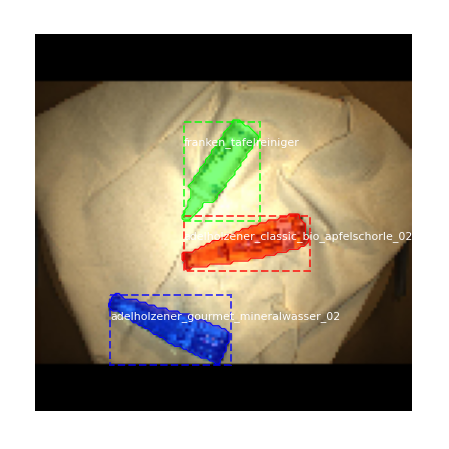

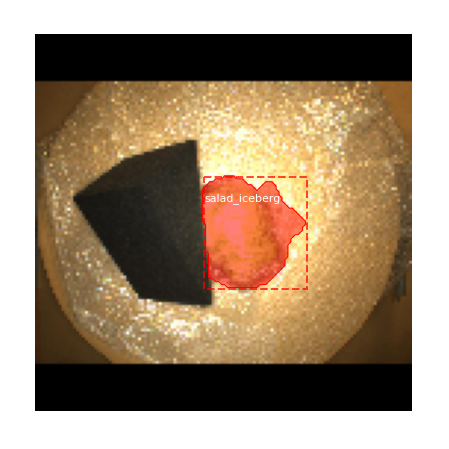

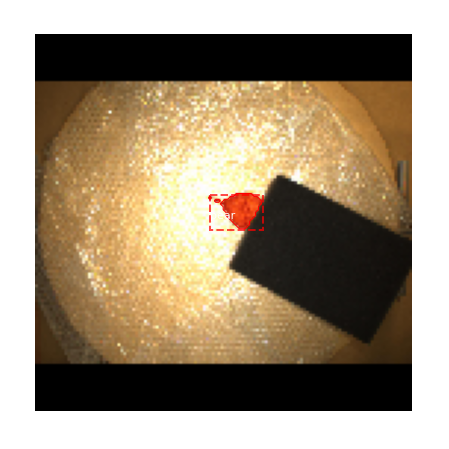

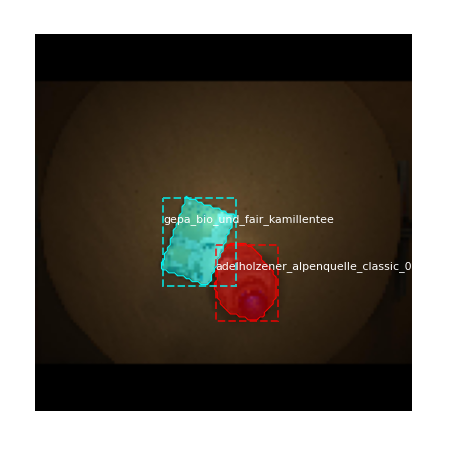

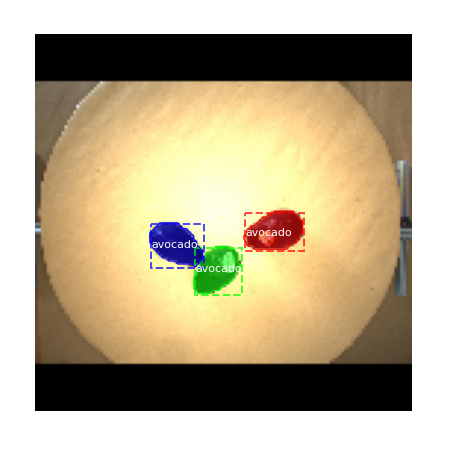

In [ ]:
for i in range(5,50,11):
  org_image, image_meta, get_class_id, get_box, get_mask =\
      mrcnn.model.load_image_gt(dataset_val, configurations, 
                            image_id=i, use_mini_mask=False)
    
    
  visualize.display_instances(org_image, get_box, get_mask, get_class_id, 
                              dataset_val.class_names, figsize=(8, 8))

**Model Evaluation**

In [ ]:
with tf.device('/CPU:0'):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=model_architecture)

APs_50 = []
APs_75 = []
precisions_lst = []
recalls_lst = []

def compute_batch_metrics(image_ids):
    for image_id in image_ids:

        # Loading images
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, configurations,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        
        # Compute AP
        result = results[0]
        AP_50, precisions, recalls, IoU =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              result['rois'], result['class_ids'], 
                             result['scores'], result['masks'],  iou_threshold=0.50)
            
        AP_75, precisions, recalls, IoU =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              result['rois'], result['class_ids'], 
                             result['scores'], result['masks'],  iou_threshold=0.75)
            

        APs_50.append(AP_50)
        APs_75.append(AP_50)
        precisions_lst.append(np.mean(precisions))
        recalls_lst.append(np.mean(recalls))
    return APs, APs_75, precisions_lst, recalls_lst

In [ ]:
# Pick a set of random images
image_ids = np.random.choice(dataset_val.image_ids, 200)

APs_50, APs_75, precisions_lst, recalls_lst = compute_batch_metrics(image_ids)

print("mAP @ IoU=50: ", np.mean(APs_50))
print("mAP @ IoU=75: ", np.mean(APs_75))
print("Average Precision: ", np.mean(precisions_lst))
print("Average Recall", np.mean(recalls_lst))

mAP @ IoU=50:  0.738
mAP @ IoU=75:  0.701
Average Precision:  0.740
Average Recall 0.734
